<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Watermark" data-toc-modified-id="Watermark-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Watermark</a></span></li><li><span><a href="#Imports-and-Setups" data-toc-modified-id="Imports-and-Setups-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports and Setups</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Autoimport-my-code" data-toc-modified-id="Autoimport-my-code-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Autoimport my code</a></span></li><li><span><a href="#Plotting" data-toc-modified-id="Plotting-2.0.2"><span class="toc-item-num">2.0.2&nbsp;&nbsp;</span>Plotting</a></span></li></ul></li></ul></li><li><span><a href="#Reminders" data-toc-modified-id="Reminders-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Reminders</a></span></li><li><span><a href="#Localization" data-toc-modified-id="Localization-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Localization</a></span></li><li><span><a href="#For-Mauro-Talk" data-toc-modified-id="For-Mauro-Talk-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>For Mauro Talk</a></span><ul class="toc-item"><li><span><a href="#Airn-repeat" data-toc-modified-id="Airn-repeat-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Airn repeat</a></span></li></ul></li></ul></div>

# Watermark

In [1]:
%load_ext watermark
%watermark -a 'Jessime Kirk' -nmv --packages numpy,scipy,pandas,sklearn,matplotlib,seaborn,networkx,notebook,jupyter_contrib_nbextensions

Jessime Kirk Wed Jan 02 2019 

CPython 3.6.7
IPython 7.2.0

numpy 1.15.4
scipy 1.1.0
pandas 0.23.4
sklearn 0.20.1
matplotlib 3.0.2
seaborn 0.9.0
networkx 2.2
notebook 5.7.4
jupyter_contrib_nbextensions 0.5.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-42-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


# Imports and Setups

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from tqdm import tqdm, trange, tqdm_notebook, tnrange

import statsmodels.api as sm
from statsmodels.formula.api import ols

import random

### Autoimport my code

In [2]:
pwd

'/home/jessime/Code/kmers3/Notebooks'

In [3]:
cd ..

/home/jessime/Code/kmers3


In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

### Plotting

In [6]:
%matplotlib inline
plt.style.use("seaborn-whitegrid")
plt.rcParams['figure.figsize'] = [6.0, 4.0]
plt.rcParams['axes.titlesize'] = 32
plt.rcParams['axes.labelsize'] = 28
plt.rcParams['xtick.labelsize'] = 28
plt.rcParams['ytick.labelsize'] = 28
plt.rcParams['legend.fontsize'] = 28
#plt.rcParams['font.family'] = 'sans-serif'
#plt.rcParams['font.sans-serif'] = 'Helvetica'
colors = [i['color'] for i in plt.rcParams['axes.prop_cycle']]

# Reminders

* All images should be saved as pdfs. They can be converted from pdf to png as necessary, but you can’t convert a png to pdf.
* When finished with a notebook, archive it with `jupyter nbconvert --to pdf nb.ipynb`

# Localization

Now that I have my new communities, let's try running the localization data again. This is from October.

In [9]:
folder = '/home/jessime/Research/mrna_lncrna/wgEncode/'
ratio_paths = [
    'hepG2_npa_ratio.tab',
    'hepG2_pap_ratio.tab',
    'k562_npa_ratio.tab',
    'k562_pap_ratio.tab'
]

labels = [
    ['HepG2', 'npa'],
    ['HepG2', 'pap'],
    ['K562', 'npa'],
    ['K562', 'pap']
]

ratio_dfs_copy = []
for path, (cell_type, method) in zip(ratio_paths, labels):
    df = pd.read_csv(folder+path, index_col=0, sep='\t')
    df['cell_type'] = cell_type
    df['method'] = method
    ratio_dfs_copy.append(df)
    
clean_data_df = pd.concat(ratio_dfs_copy)
clean_data_df.drop(columns=['length', 'nuc_counts', 'cyto_counts'], inplace=True)
print(clean_data_df.shape)
clean_data_df.head()

(262716, 6)


transcript_name  nuc_norm  cyto_norm  % nuclear cell_type  \
transcript_id                                                               
UNSPLICED2       MIR1302-2HG-un   0.00000   0.000000        NaN     HepG2   
UNSPLICED3           FAM138A-un   0.00000   0.000000        NaN     HepG2   
UNSPLICED4      RP11-34P13.7-un   0.03612   0.005267   0.872729     HepG2   
UNSPLICED5      RP11-34P13.8-un   0.00000   0.000000        NaN     HepG2   
UNSPLICED6     RP11-34P13.14-un   0.00000   0.000000        NaN     HepG2   

              method  
transcript_id         
UNSPLICED2       npa  
UNSPLICED3       npa  
UNSPLICED4       npa  
UNSPLICED5       npa  
UNSPLICED6       npa

**WARNING:** I'm going to do something a little stupid here. The ids I have in this csv don't match what I'm using now. But, I'm fairly confident that it's just that I was using a different naming scheme, where I added `-UN` or `-SP` to the transcript common names. The order should be the same. If I have to do debugging later, this is a great place to start looking. 

In [14]:
groups = '/home/jessime/Research/mrna_lncrna/v26_extend_groups2.csv'
groups = pd.read_csv(groups, index_col=0)
groups = groups.iloc[:-9] #strip the doped transcripts
groups.head()

group  lncRNA  spliced    type
MIR1302-2HG-UN        5    True    False  lnc_un
FAM138A-UN            5    True    False  lnc_un
RP11-34P13.7-UN       7    True    False  lnc_un
RP11-34P13.8-UN       5    True    False  lnc_un
RP11-34P13.14-UN      5    True    False  lnc_un

In [15]:
groups_log = '/home/jessime/Research/mrna_lncrna/v26_extend_log_groups2.csv'
groups_log = pd.read_csv(groups_log, index_col=0)
groups_log = groups_log.iloc[:-9] #strip the doped transcripts

Getting fancy labels on the plots doesn't matter too much, since they'll all eventually be edited in Illustrator.

In [16]:
group_ls = groups['group'].values.tolist() * 4
clean_data_df['group'] = group_ls

In [17]:
group_ls_log = groups_log['group'].values.tolist() * 4
clean_data_df['group_log'] = group_ls_log

In [18]:
plotting_data = clean_data_df[(clean_data_df['nuc_norm'] > .1) |
                              (clean_data_df['cyto_norm'] > .1)]

In [30]:
plt.rcParams['figure.figsize'] = [14.0, 6.0]
pal = sns.color_palette("tab20", 20)[::2]
pal.append((0, 0, 0))

In [39]:
current_plot = plotting_data[(plotting_data['cell_type'] == 'HepG2') & 
                             (plotting_data['method'] == 'npa')]

plt.title('HepG2, Non-PolyA')
sns.boxenplot(x='group', 
              y='% nuclear', 
              data=current_plot, palette=pal)
outfile = '/home/jessime/Research/pics/local_HepG2_npa.pdf'
plt.savefig(outfile, bbox_inches='tight', dpi=600)
plt.show()

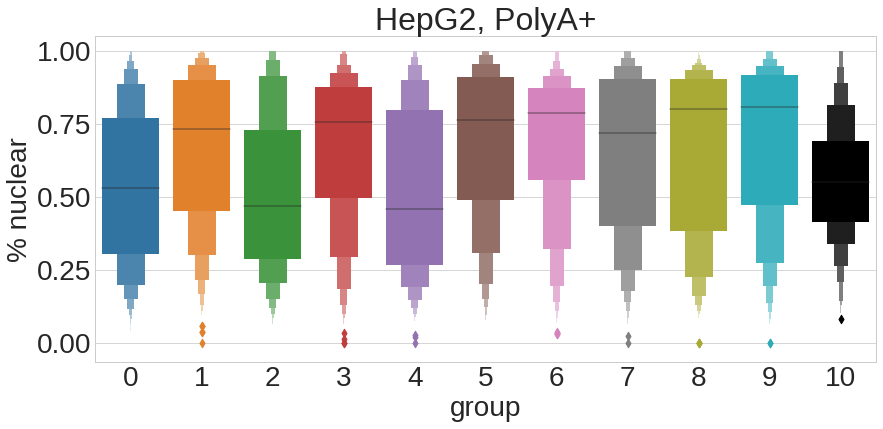

In [40]:
current_plot = plotting_data[(plotting_data['cell_type'] == 'HepG2') & 
                             (plotting_data['method'] == 'pap')]

plt.title('HepG2, PolyA+')
sns.boxenplot(x='group', 
              y='% nuclear', 
              data=current_plot, palette=pal)
outfile = '/home/jessime/Research/pics/local_HepG2_pap.pdf'
plt.savefig(outfile, bbox_inches='tight', dpi=600)
plt.show()

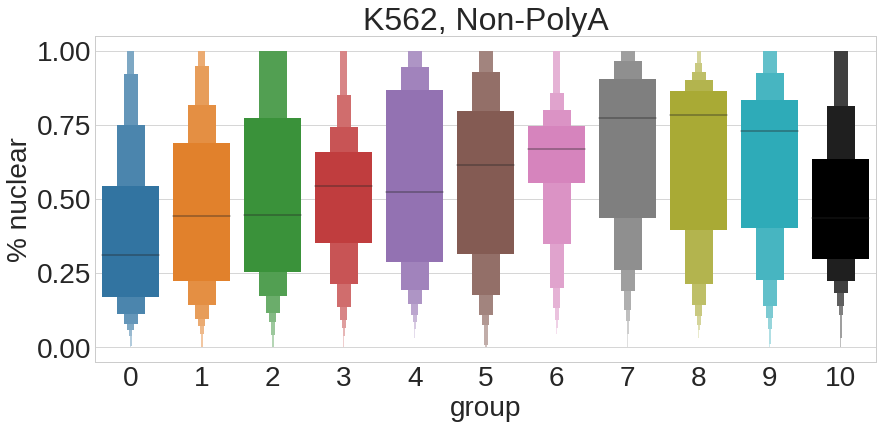

In [41]:
current_plot = plotting_data[(plotting_data['cell_type'] == 'K562') & 
                             (plotting_data['method'] == 'npa')]

plt.title('K562, Non-PolyA')
sns.boxenplot(x='group', 
              y='% nuclear', 
              data=current_plot, palette=pal)
outfile = '/home/jessime/Research/pics/local_K562_npa.pdf'
plt.savefig(outfile, bbox_inches='tight', dpi=600)
plt.show()

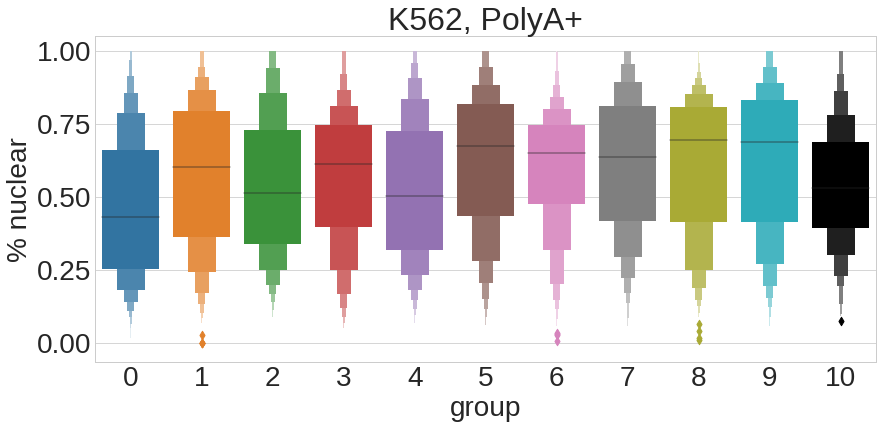

In [42]:
current_plot = plotting_data[(plotting_data['cell_type'] == 'K562') & 
                             (plotting_data['method'] == 'pap')]

plt.title('K562, PolyA+')
sns.boxenplot(x='group', 
              y='% nuclear', 
              data=current_plot, palette=pal)
outfile = '/home/jessime/Research/pics/local_K562_pap.pdf'
plt.savefig(outfile, bbox_inches='tight', dpi=600)
plt.show()

That group 10 will probably have to be cut. But let's do the same thing for log.

Note the the community ordering here is not the same. 

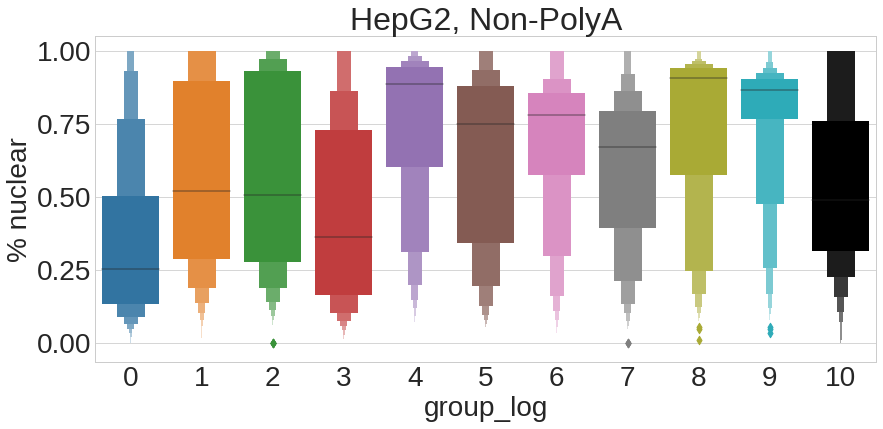

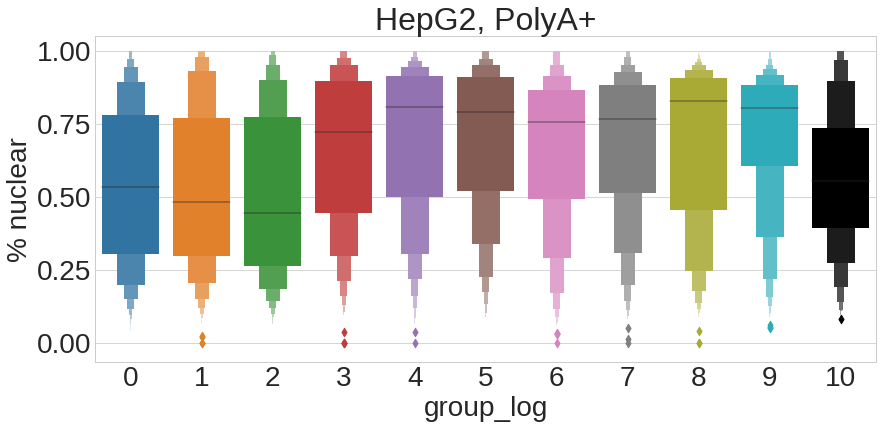

In [43]:
cell_type_ls = ['HepG2', 'HepG2', 'K562', 'K562']
method_ls = ['npa', 'pap', 'npa', 'pap']
title_ls = ['Non-PolyA', 'PolyA+', 'Non-PolyA', 'PolyA+']

for ct, m, t in zip(cell_type_ls, method_ls, title_ls):
    current_plot = plotting_data[(plotting_data['cell_type'] == ct) & 
                                 (plotting_data['method'] == m)]

    plt.title(f'{ct}, {t}')
    sns.boxenplot(x='group_log', 
                  y='% nuclear', 
                  data=current_plot, palette=pal)
    outfile = f'/home/jessime/Research/pics/local_{ct}_{m}_log.pdf'
    plt.savefig(outfile, bbox_inches='tight', dpi=600)
    plt.show()

In [50]:
renamed = current_plot.rename(columns={'% nuclear': 'nuclear'})
model = ols('nuclear ~ group_log', data=renamed).fit()
anova = sm.stats.anova_lm(model, typ=2)

In [52]:
display(anova)

sum_sq       df            F         PR(>F)
group_log    62.021837      1.0  1089.593404  5.893113e-235
Residual   1801.239792  31644.0          NaN            NaN

In [60]:
tukeyhsd = sm.stats.multicomp.pairwise_tukeyhsd(renamed['nuclear'], renamed['group'])
summary = tukeyhsd.summary()

Okay, Let's store all of the corresponding stats (ANOVA and tukeyHSD) for this.

In [61]:
!mkdir /home/jessime/Research/mrna_lncrna/wgEncode/group_stats

In [66]:
cell_type_ls = ['HepG2', 'HepG2', 'K562', 'K562']
method_ls = ['npa', 'pap', 'npa', 'pap']

for ct, m in zip(cell_type_ls, method_ls):
    current_plot = plotting_data[(plotting_data['cell_type'] == ct) & 
                                 (plotting_data['method'] == m)]
    current_plot = current_plot.rename(columns={'% nuclear': 'nuclear'})
    
    #normal
    model = ols('nuclear ~ group', data=current_plot).fit()
    anova = sm.stats.anova_lm(model, typ=2)
    outfile = f'/home/jessime/Research/mrna_lncrna/wgEncode/group_stats/anova_{ct}_{m}.csv'
    anova.to_csv(outfile)
    tukeyhsd = sm.stats.multicomp.pairwise_tukeyhsd(renamed['nuclear'], renamed['group'])
    summary = tukeyhsd.summary()
    outfile = f'/home/jessime/Research/mrna_lncrna/wgEncode/group_stats/tukeyhsd_{ct}_{m}.csv' 
    with open(outfile, 'w') as outfile:
        outfile.write(summary.as_csv())
        
    #log
    model = ols('nuclear ~ group', data=current_plot).fit()
    anova = sm.stats.anova_lm(model, typ=2)
    outfile = f'/home/jessime/Research/mrna_lncrna/wgEncode/group_stats/anova_{ct}_{m}_log.csv'
    anova.to_csv(outfile)
    tukeyhsd = sm.stats.multicomp.pairwise_tukeyhsd(renamed['nuclear'], renamed['group'])
    summary = tukeyhsd.summary()
    outfile = f'/home/jessime/Research/mrna_lncrna/wgEncode/group_stats/tukeyhsd_{ct}_{m}_log.csv' 
    with open(outfile, 'w') as outfile:
        outfile.write(summary.as_csv())    

Hmm... I guess final products like this should start going into the dropbox folder.

In [67]:
!mkdir /home/jessime/Dropbox/xist-like-rnas/localization

In [68]:
!mv /home/jessime/Research/mrna_lncrna/wgEncode/group_stats/ \
/home/jessime/Dropbox/xist-like-rnas/localization/

In [69]:
!mv /home/jessime/Research/pics/local_* \
/home/jessime/Dropbox/xist-like-rnas/localization/

# For Mauro Talk

> Jessime, hope your interview went well – I am giving a talk at Cornell next week and would like for you to generate the Xist vs Kcnq1ot1 vs random k-mer comparisons using k = 1 through 6 – see attached image. I think you’ve done this before. I want to know at what length k-mer the results become significant.
> 
> Thanks
> 
> Mauro

Let's run a test with 6mers, then put it into a loop.

In [7]:
%aimport kmer_counts

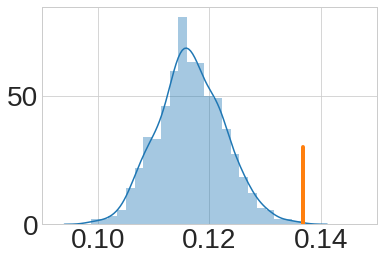

0.0


In [35]:
xka = '/home/jessime/Research/indv_seqs/M5_XKA.fa'
k = 6
mean = f'/home/jessime/Code/old_kmers/data/M5_transcripts01_mean{k}.npy'
std = f'/home/jessime/Code/old_kmers/data/M5_transcripts01_std{k}.npy'
counter = kmer_counts.BasicCounter(infasta=xka, k=k, mean=mean, std=std, log2=False)
counter.get_counts()
sim = np.corrcoef(counter.counts)
x_vs_k = sim[0, 1]

counter.silent = True
kcnq1_ls = list(counter.seqs[1])
rand_k_score = []
greater_count = 0
for i in tnrange(1000):
    random.shuffle(kcnq1_ls)
    rand_k = ''.join(kcnq1_ls)
    counter.seqs[1] = rand_k
    counter.get_counts()
    sim = np.corrcoef(counter.counts)
    x_vs_rand_k = sim[0, 1]
    rand_k_score.append(x_vs_rand_k)
    if x_vs_rand_k >= x_vs_k:
        greater_count += 1
        
sns.distplot(rand_k_score)
plt.plot((x_vs_k, x_vs_k), (0, 30), linewidth=4)
plt.xlim((.09, .15))
outfile = f'/home/jessime/Research/pics/M5_x_vs_k_{k}.pdf'
plt.savefig(outfile, bbox_inches='tight', dpi=600)
plt.show()
print(greater_count/1000)

In [21]:
!cat /home/jessime/Research/indv_seqs/xist_v22.fa \
/home/jessime/Research/indv_seqs/kcnq1ot1_v22.fa > \
/home/jessime/Research/indv_seqs/v22_XK.fa

Now let's do the rest of them.

x_vs_k:  0.13390381789847594


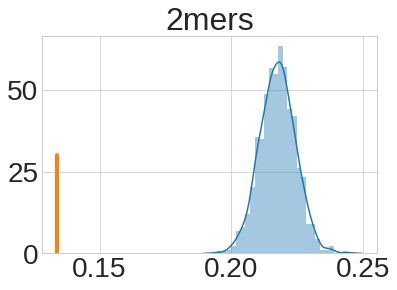

p-value:  1.0


x_vs_k:  0.24314582702873722


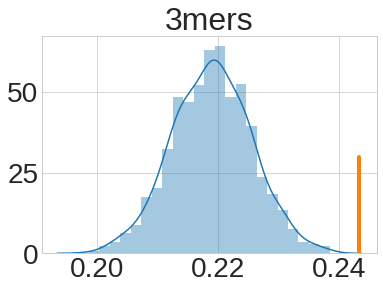

p-value:  0.0


x_vs_k:  0.2536452930970581


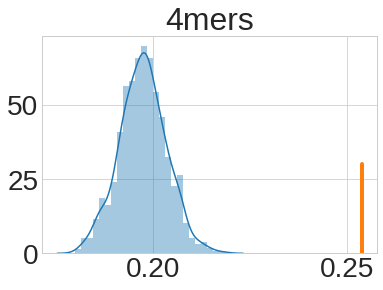

p-value:  0.0


x_vs_k:  0.20691692703244602


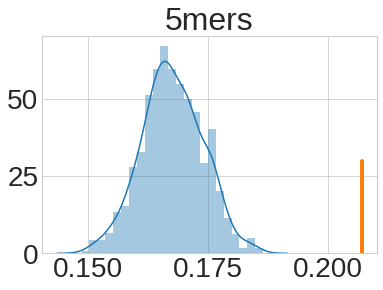

p-value:  0.0


In [34]:
for k in range(2, 6):
    mean = f'/home/jessime/Code/old_kmers/data/M5_transcripts01_mean{k}.npy'
    std = f'/home/jessime/Code/old_kmers/data/M5_transcripts01_std{k}.npy'
    counter = kmer_counts.BasicCounter(infasta=xka, k=k, mean=mean, std=std, log2=False)
    counter.get_counts()
    sim = np.corrcoef(counter.counts)
    x_vs_k = sim[0, 1]
    print('x_vs_k: ', x_vs_k)
    
    counter.silent = True
    kcnq1_ls = list(counter.seqs[1])
    rand_k_score = []
    greater_count = 0
    for i in tnrange(1000):
        random.shuffle(kcnq1_ls)
        rand_k = ''.join(kcnq1_ls)
        counter.seqs[1] = rand_k
        counter.get_counts()
        sim = np.corrcoef(counter.counts)
        x_vs_rand_k = sim[0, 1]
        assert x_vs_rand_k != x_vs_k
        rand_k_score.append(x_vs_rand_k)
        if x_vs_rand_k >= x_vs_k:
            greater_count += 1

    sns.distplot(rand_k_score)
    plt.plot((x_vs_k, x_vs_k), (0, 30), linewidth=4)
    #plt.xlim((.00, .15))
    plt.title(f'{k}mers')
    outfile = f'/home/jessime/Research/pics/M5_x_vs_k_{k}.pdf'
    plt.savefig(outfile, bbox_inches='tight', dpi=600)
    plt.show()
    print('p-value: ', greater_count/1000)

In [29]:
x_vs_k

0.24314582702873722

## Airn repeat

> Jessime, would it be hard to make this same series of plots with Airn?

 

In [7]:
%aimport kmer_counts


x_vs_a:  -0.224811736074942


/home/jessime/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


p-value:  1.0



x_vs_a:  -0.09727421892908268


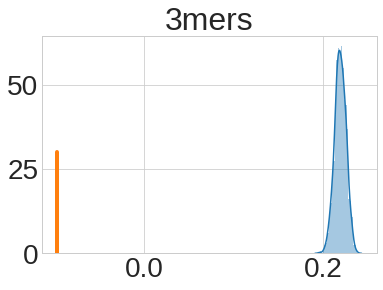

p-value:  1.0



x_vs_a:  -0.030072420159572604


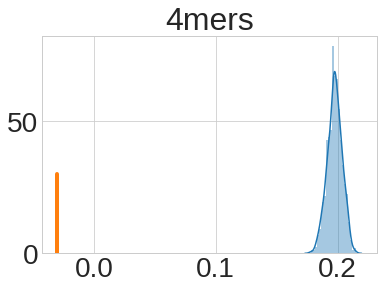

p-value:  1.0



x_vs_a:  0.017135400622392716


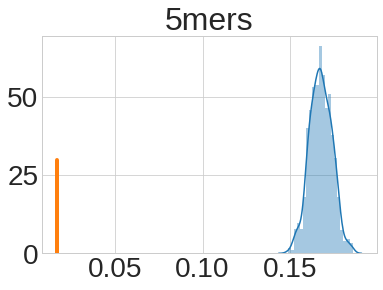

p-value:  1.0



x_vs_a:  0.02685225168193628


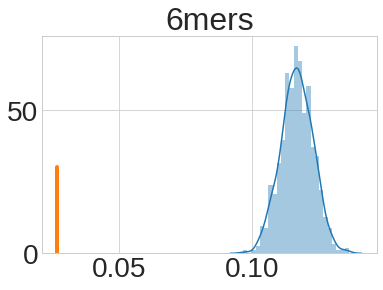

p-value:  1.0


In [12]:
xka = '/home/jessime/Research/indv_seqs/M5_XKA.fa'
for k in range(2, 7):
    mean = f'/home/jessime/Code/old_kmers/data/M5_transcripts01_mean{k}.npy'
    std = f'/home/jessime/Code/old_kmers/data/M5_transcripts01_std{k}.npy'
    counter = kmer_counts.BasicCounter(infasta=xka, k=k, mean=mean, std=std, log2=False)
    counter.get_counts()
    sim = np.corrcoef(counter.counts)
    x_vs_a = sim[0, 2]
    print('x_vs_a: ', x_vs_a)
    
    counter.silent = True
    airn_ls = list(counter.seqs[1])
    rand_a_score = []
    greater_count = 0
    for i in tnrange(1000):
        random.shuffle(airn_ls)
        rand_a = ''.join(airn_ls)
        counter.seqs[2] = rand_a
        counter.get_counts()
        sim = np.corrcoef(counter.counts)
        x_vs_rand_a = sim[0, 2]
        assert x_vs_rand_a != x_vs_a
        rand_a_score.append(x_vs_rand_a)
        if x_vs_rand_a >= x_vs_a:
            greater_count += 1

    sns.distplot(rand_a_score)
    plt.plot((x_vs_a, x_vs_a), (0, 30), linewidth=4)
    #plt.xlim((.00, .15))
    plt.title(f'{k}mers')
    outfile = f'/home/jessime/Research/pics/M5_x_vs_a_{k}.pdf'
    plt.savefig(outfile, bbox_inches='tight', dpi=600)
    plt.show()
    print('p-value: ', greater_count/1000)